<a href="https://colab.research.google.com/github/Debottam/MachinLearningEx/blob/master/LSHashAnomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

Using TensorFlow backend.


In [0]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [0]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [5]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [6]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
x_train_bkg = x_train[np.where((y_train!=4)&(y_train!=5)&(y_train!=6))]

In [10]:
x_train_bkg.shape

(42819, 784)

In [0]:
from sklearn.model_selection import train_test_split
x_train_bkg,valid_x_train_bkg = train_test_split(x_train_bkg,
                                                 test_size=0.2, 
                                                 random_state=13)

In [12]:
autoencoder_train = autoencoder.fit(x_train_bkg, x_train_bkg,
                                epochs=50,
                                batch_size=256,
                                shuffle=True,
                                validation_data=(valid_x_train_bkg, valid_x_train_bkg))




Train on 34255 samples, validate on 8564 samples
Epoch 1/50





34255/34255 [==============================] - 1s 33us/step - loss: 0.0689 - val_loss: 0.0417
Epoch 2/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0338 - val_loss: 0.0285
Epoch 3/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0252 - val_loss: 0.0226
Epoch 4/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0208 - val_loss: 0.0193
Epoch 5/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0182 - val_loss: 0.0173
Epoch 6/50
34255/34255 [==============================] - 1s 28us/step - loss: 0.0165 - val_loss: 0.0160
Epoch 7/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0153 - val_loss: 0.0149
Epoch 8/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0143 - val_loss: 0.0140
Epoch 9/50
34255/34255 [==============================] - 1s 27us/step - loss: 0.0136 - val_loss: 0.013

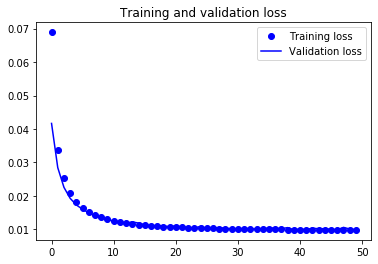

In [13]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
truth = np.zeros(len(y_test))

In [0]:
truth[np.where((y_test==4)|(y_test==5)|(y_test==6))]= 1

In [0]:
predict_nums=autoencoder.predict(x_test)

In [17]:
predict_nums.shape

(10000, 784)

In [0]:
predict_loss_mse = np.mean(np.power(x_test - predict_nums, 2), axis =1)

In [19]:
predict_loss_mse.shape

(10000,)

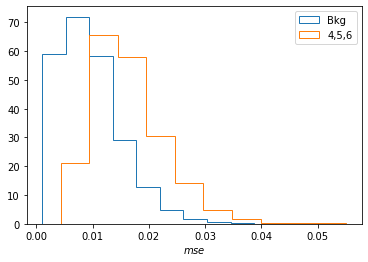

In [20]:

l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg', density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6', density=True)
plt.legend(loc='best')
#plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$mse$')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
No handles with labels found to put in legend.


roc_auc = 0.8058160592510971


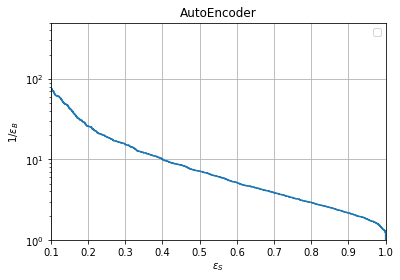

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(truth, predict_loss_mse)
print("roc_auc =", roc_auc_score(truth, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [0]:
# Utility function to visualize the outputs of PCA and t-SNE

def num_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
encoded_test = encoder.predict(x_test)
encoded_train_bkg = encoder.predict(x_train_bkg)

In [24]:
from sklearn.manifold import TSNE
import time
time_start = time.time()
RS = 123
fashion_tsne = TSNE(random_state=RS).fit_transform(encoded_test)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 97.2999427318573 seconds


In [0]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
import matplotlib.patheffects as PathEffects

(<Figure size 576x576 with 1 Axes>,
 [Text(48.210613, 41.54651, '0'),
  Text(-52.862995, 35.35172, '1'),
  Text(62.02803, -0.3901118, '2'),
  Text(30.306076, -4.038865, '3'),
  Text(-39.561703, -33.874535, '4'),
  Text(6.851296, 8.941788, '5'),
  Text(2.1050944, 57.634216, '6'),
  Text(-20.630203, -23.129177, '7'),
  Text(17.933207, -29.830814, '8'),
  Text(-30.038382, -48.05467, '9')])

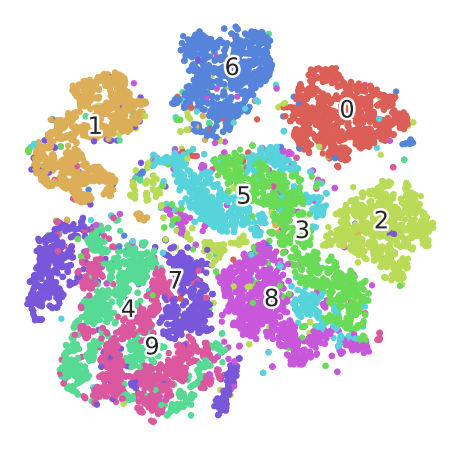

In [26]:
num_scatter(fashion_tsne, y_test)

(<Figure size 576x576 with 1 Axes>,
 [Text(6.371485, -5.4565363, '0'), Text(-6.34074, 9.021685, '1')])

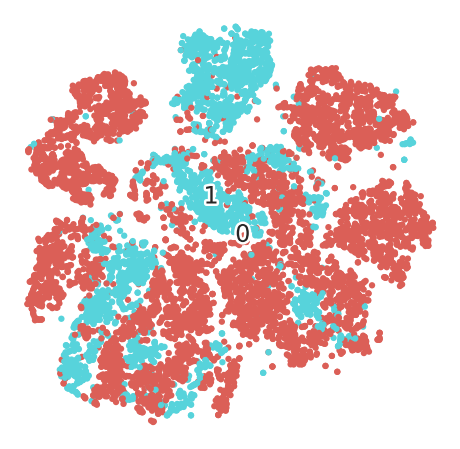

In [27]:
num_scatter(fashion_tsne, truth)

In [0]:
from sklearn.cluster import KMeans

In [29]:
Kmean = KMeans(n_clusters=2)
Kmean.fit(encoded_test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
truth_kmeans = Kmean.labels_

In [31]:
truth_kmeans.shape

(10000,)

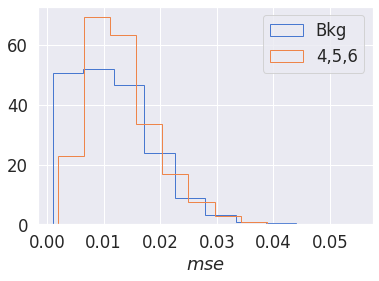

In [32]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if truth_kmeans[i]==0:
        l_rec_0.append(predict_loss_mse[i])
    else:
        l_rec_1.append(predict_loss_mse[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='Bkg',density=True)
plt.hist(l_rec_1, histtype='step', label='4,5,6',density=True)
plt.legend(loc='best')
#plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$mse$')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
No handles with labels found to put in legend.


roc_auc = 0.5818645790732782


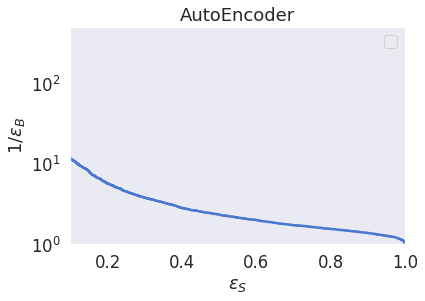

In [33]:
fpr, tpr, thrs = roc_curve(truth_kmeans, predict_loss_mse)
print("roc_auc =", roc_auc_score(truth_kmeans, predict_loss_mse))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('AutoEncoder')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

In [34]:
truth

array([0., 0., 0., ..., 1., 1., 1.])

In [35]:
truth_kmeans

array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

In [36]:
np.mean(np.power(truth - truth_kmeans, 2))

0.4819

(<Figure size 576x576 with 1 Axes>,
 [Text(-24.880135, 2.8289816, '0'), Text(38.210926, -6.510545, '1')])

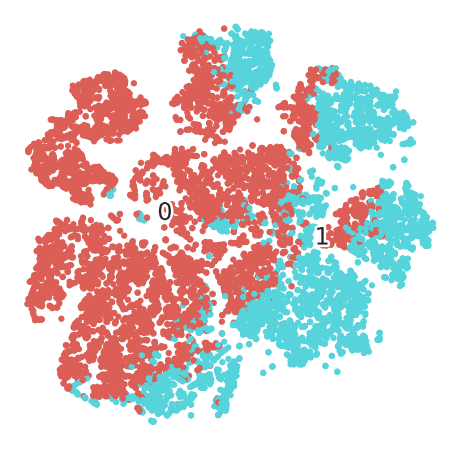

In [37]:
num_scatter(fashion_tsne, truth_kmeans)

In [0]:
import numpy as np
    
class HashTable:
    def __init__(self, hash_size, inp_dimensions):
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.hash_table = dict()
        self.projections = np.random.randn(self.hash_size, inp_dimensions)
        
    def generate_hash(self, inp_vector):
        bools = (np.dot(inp_vector, self.projections.T) > 0).astype('int')
        return ''.join(bools.astype('str'))

    def __setitem__(self, inp_vec, label):
        hash_value = self.generate_hash(inp_vec)
        self.hash_table[hash_value] = self.hash_table\
            .get(hash_value, list()) + [label]
        
    def __getitem__(self, inp_vec):
        hash_value = self.generate_hash(inp_vec)
        return self.hash_table.get(hash_value, [])
        
# hash_table = HashTable(hash_size=4, inp_dimensions=20)

In [0]:
class LSH:
    def __init__(self, num_tables, hash_size, inp_dimensions):
        self.num_tables = num_tables
        self.hash_size = hash_size
        self.inp_dimensions = inp_dimensions
        self.hash_tables = list()
        for i in range(self.num_tables):
            self.hash_tables.append(HashTable(self.hash_size, self.inp_dimensions))
    
    def __setitem__(self, inp_vec, label):
        for table in self.hash_tables:
            table[inp_vec] = label
    
    def __getitem__(self, inp_vec):
        results = list()
        for table in self.hash_tables:
            results.extend(table[inp_vec])
        return list(set(results))

In [0]:
hash_table = HashTable(hash_size=1, inp_dimensions=32)

In [0]:

hash_table.generate_hash(encoded_test[4])

'1'

In [0]:
hash_size = 10
sample_size, vec_size = encoded_train_bkg.shape
projections = np.random.randn(hash_size, vec_size)

In [25]:
vec_size

32

In [0]:
hashed_encoded = list()

In [0]:
for i in range(sample_size):
  bools = ''
  for j in range(hash_size):
    bool = (np.dot(encoded_train_bkg[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
    #print(bools)
  hashed_encoded.append(bools)

In [28]:
len(hashed_encoded)

34255

In [29]:
sample_size

34255

In [0]:
def getDuplicatesWithInfo(hashed_encoded):
    ''' Get duplicate element in a list along with thier indices in list
     and frequency count'''
    dictOfElems = dict()
    index = 0
    # Iterate over each element in list and keep track of index
    for elem in hashed_encoded:
        # If element exists in dict then keep its index in lisr & increment its frequency
        if elem in dictOfElems:
            dictOfElems[elem][0] += 1
            dictOfElems[elem][1].append(index)
        else:
            # Add a new entry in dictionary 
            dictOfElems[elem] = [1, [index]]
        index += 1    
 
    dictOfElems = { key:value for key, value in dictOfElems.items() }
    return dictOfElems

In [31]:
dictOfElems = getDuplicatesWithInfo(hashed_encoded)
listHash = list()
for key, value in dictOfElems.items():
  listHash.append(key)
  print('Element = ', key , ' :: Repeated Count = ', value[0] , ' :: Index Positions =  ', value[1])    

Element =  0100001000  :: Repeated Count =  5918  :: Index Positions =   [0, 5, 8, 38, 40, 44, 54, 55, 56, 63, 65, 78, 79, 90, 91, 99, 107, 108, 113, 118, 121, 122, 135, 146, 147, 154, 155, 164, 166, 184, 206, 209, 229, 233, 243, 271, 276, 277, 285, 293, 303, 307, 310, 320, 323, 326, 336, 337, 348, 350, 364, 367, 372, 374, 382, 393, 403, 407, 412, 414, 421, 422, 425, 427, 428, 429, 440, 442, 459, 466, 484, 500, 506, 518, 525, 526, 537, 546, 557, 560, 561, 563, 565, 573, 577, 583, 586, 588, 595, 597, 598, 600, 601, 611, 619, 628, 630, 632, 641, 642, 647, 653, 654, 668, 673, 683, 689, 697, 725, 727, 743, 757, 760, 761, 762, 763, 764, 777, 794, 796, 807, 808, 819, 824, 827, 833, 835, 837, 843, 844, 846, 851, 852, 853, 854, 859, 860, 863, 864, 865, 876, 880, 881, 882, 890, 891, 899, 903, 905, 909, 915, 922, 924, 931, 941, 944, 945, 948, 955, 958, 971, 975, 984, 993, 994, 995, 1004, 1007, 1010, 1013, 1030, 1031, 1034, 1043, 1044, 1050, 1053, 1056, 1072, 1074, 1075, 1082, 1099, 1103, 1104, 1

In [0]:
 listHash = np.array(listHash)

In [33]:
listHash.shape

(141,)

In [0]:
sample_size, vec_size = encoded_test.shape

In [0]:
hash_truth = list()

In [36]:
for i in range(sample_size):
  bools = ''
  a = 1
  for j in range(hash_size):
    bool = (np.dot(encoded_test[i], projections[j].T) > 0).astype('int')
    #print(bool)
    bools += str(bool)
  print(bools)
  for k in range(141):
    #print("bools: ",bools)
    #print("listHash: ", listHash[k])
    if listHash[k]== bools:
      print("listHash: ", listHash[k])
      a=0
      print(a)
      break
  hash_truth.append(a)

0100011010
1
1
1
1
1
1
listHash:  0100011010
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0100001000
listHash:  0100001000
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1100101000
1
1
1
1
1
1
1
1
1
1
listHash:  1100101000
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0100001000
listHash:  0100001000
0
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: ignored

In [123]:
hash_truth[0]

0

In [47]:
from difflib import SequenceMatcher
a = listHash[0]
b = listHash[1]
SequenceMatcher(None, a, b).ratio()

0.9

In [0]:
a=set(str1.split())
b=set(str2.split())
union = list(set(a+b))
intersection = list(set(a) - (set(a)-set(b)))
union

TypeError: ignored

In [0]:
str1 = set(listHash[0].split())
str2 = set(listHash[1].split())
len(str1.intersection(str2))
#float((str1 & str2)) / (str1 | str2)

0

In [0]:
#def DistJaccard(str1, str2):
str1 = set(str1.split())
str2 = set(str2.split())
    #return float(len(str1 & str2)) / len(str1 | str2)


In [0]:
dictOfhash = dict.fromkeys(listHash,list())
#dictOfhash['0101000111'].append(1)

In [0]:
#dictOfhash = dict.fromkeys(listHash,list())
for i in range(26):
  print("i ",i)
  for j in range(26):
    if j!=i:
      dist = SequenceMatcher(None, listHash[i], listHash[j]).ratio()
      #print("dist: ",dist)
      if dist>0.8:
        print("j ",j, " dist: ", dist)
        dictOfhash[listHash[i]].append(listHash[j])


i  0
j  3  dist:  0.9
j  6  dist:  0.9
j  8  dist:  0.9
j  11  dist:  0.9
j  14  dist:  0.9
j  18  dist:  0.9
j  23  dist:  0.9
i  1
j  2  dist:  0.9
j  7  dist:  0.9
j  9  dist:  0.9
j  17  dist:  0.9
i  2
j  1  dist:  0.9
j  4  dist:  0.9
j  6  dist:  0.9
j  9  dist:  0.9
j  10  dist:  0.9
j  14  dist:  0.9
i  3
j  0  dist:  0.9
j  4  dist:  0.9
j  6  dist:  0.9
j  8  dist:  0.9
j  10  dist:  0.9
j  11  dist:  0.9
j  12  dist:  0.9
j  13  dist:  0.9
j  16  dist:  0.9
j  19  dist:  0.9
j  21  dist:  0.9
j  25  dist:  0.9
i  4
j  2  dist:  0.9
j  3  dist:  0.9
j  5  dist:  0.9
j  9  dist:  0.9
j  10  dist:  0.9
j  14  dist:  0.9
j  19  dist:  0.9
j  24  dist:  0.9
i  5
j  4  dist:  0.9
j  8  dist:  0.9
j  14  dist:  0.9
j  24  dist:  0.9
i  6
j  0  dist:  0.9
j  2  dist:  0.9
j  3  dist:  0.9
j  7  dist:  0.9
j  10  dist:  0.9
j  11  dist:  0.9
j  13  dist:  0.9
j  20  dist:  0.9
j  22  dist:  0.9
i  7
j  1  dist:  0.9
j  6  dist:  0.9
j  18  dist:  0.9
i  8
j  0  dist:  0.9
j  3  dist

In [0]:
len(dictOfhash['0101000111'])

280

In [0]:
for key, value in dictOfhash.items():
  #listHash.append(key)
  print('Element = ', key , ' :: Repeated Count = ', value)  

Element =  1101001011  :: Repeated Count =  ['1101000111', '1101001111', '1101000011', '1101010111', '1111001011', '1101011011', '1100001011', '1111001111', '1101011111', '1111010111', '1111011011', '1111011111', '1111000111', '1101001111', '1111010111', '1110001111', '1111001011', '1101001011', '1111000111', '1101001111', '1101000011', '1110001111', '1101010111', '1101010011', '1100001111', '1001000111', '0111000111', '0101000111', '1100000111', '1111001111', '1101000111', '1111000011', '1111010111', '1110001111', '1111001011', '0111000111', '1111010011', '1111000111', '1101000011', '1111001011', '1111010011', '1101001011', '1111001111', '1101000111', '1101011111', '1110001111', '1101010111', '1100001111', '0101001111', '1001001111', '1111011111', '1101001111', '1101011011', '1101001011', '1101000111', '1111000011', '1101010011', '1100000111', '1111011111', '1111001111', '1111000111', '1101010111', '1111001011', '1111011011', '1111010011', '1111001111', '1101000111', '1111000111', '11